# Brief Introduction

Using [Financial PhraseBank (Kaggle)](https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news) from Kaggle as the dataset.
After cleaning the data, I trained several models:
- Naive Bayes + TF-IDF
- LSTM
- [**FinBERT**](https://huggingface.co/yiyanghkust/finbert-tone), developed by the research team at HKUST, based on the BERT-base architecture and fine-tuned on financial news and sentiment corpora.
- Fine-tuned FinBERT

The fine-tuned FinBERT achieved a test accuracy of 0.88.

Finally, I used the model to predict new data from chiapudding/kaggle-financial-sentiment￼, reaching 0.76 accuracy, which outperforms the original FinBERT-tone (0.69).

I assume this improvement comes from fine-tuning FinBERT-tone to perform better on financial news titles, while the original model was trained on general financial news. After fine-tuning, the model better captures sentiment in headline-style text.

# 	1.	Data Collection & Cleaning

## load dataset
using [Financial PhraseBank (Kaggle)](https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news) as dataset
load dataset and add columnnames
- "data" for Naive Bayes + TF-Idata and LSTM with all lower case words
- "data_bert" for BERT 

In [87]:
import pandas as pd
data = pd.read_csv("all-data.csv", encoding="ISO-8859-1")
data = data.iloc[:, :2].copy()
data.columns = ['sentiment','text']
data_bert = data.copy()

In [88]:
data

,sentiment,text
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower...
4841,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4843,negative,Net sales of the Paper segment decreased to EU...


##  clean data 
for "data" using in  Naive Bayes + TF-Idata and LSTM:
- label encoder
- clean data for A unified word list
    1. replace currency symbols to interfering with word segmentation
    2. replace numbers to interfering with word segmentation
    3. replaced all with spaces except for English letters, apaces, hyphens, and apostrophes
    4. merge consecutive spaces into one
    5. remove low frequency words
    6. remove st






In [89]:
# pip install torch torchmetrics scikit-learn
import re, math, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# preprocess data for tokenize
def clean_tokenize(s: str):
    s = s.lower()
    s = re.sub(r'[\$€£¥%]', ' ', s)
    s = re.sub(r'\d+([.,]\d+)*', ' ', s)
    s = re.sub(r"[^a-z\s\-']", ' ', s)
    s = re.sub(r"\s+", ' ', s).strip()
    return s.split()

# build vocabulary dictionary
def build_vocab(texts, min_freq=2, max_size=20000):
    counter = Counter()
    for t in texts:
        counter.update(clean_tokenize(t))
    # filter low freq words and max size
    itms = [w for w,c in counter.items() if c>=min_freq]
    itms = sorted(itms, key=lambda w: (-counter[w], w))[:max_size-2]
    stoi = {'<PAD>':0, '<UNK>':1}
    for i,w in enumerate(itms, start=2):
        stoi[w]=i
    itos = {i:w for w,i in stoi.items()}
    return stoi, itos

def encode(tokens, stoi):
    return [stoi.get(tok, stoi['<UNK>']) for tok in tokens]
# split data
X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['sentiment'], test_size=0.2, random_state=42, stratify=data['sentiment']
)
# label encoder
le = LabelEncoder()
y_train_id = le.fit_transform(y_train)
y_test_id  = le.transform(y_test)
num_classes = len(le.classes_)

# vocabulary list
stoi, itos = build_vocab(X_train.tolist(), min_freq=2, max_size=20000)
vocab_size = len(stoi)

## balance of classes

In [90]:
import numpy as np
from collections import Counter

class_counts = Counter(y_train)
total_samples = len(y_train)
number_of_classes = len(class_counts)

class_weight = {
    class_label: total_samples / (number_of_classes * sample_count)
    for class_label, sample_count in class_counts.items()
}
weights = np.array([class_weight[label] for label in y_train])

# 	2.	Exploratory Data Analysis (EDA)

## emotion distribution bar chart

The bar chart shows the number of samples for each of the three emotional categories: neutral has the highest count, approximately 3000; positive comes next, around 1400; and negative has the lowest count, about 600. Overall, the dataset leans towards neutral samples, with relatively fewer positive and negative samples.

Text(0, 0.5, 'Count')

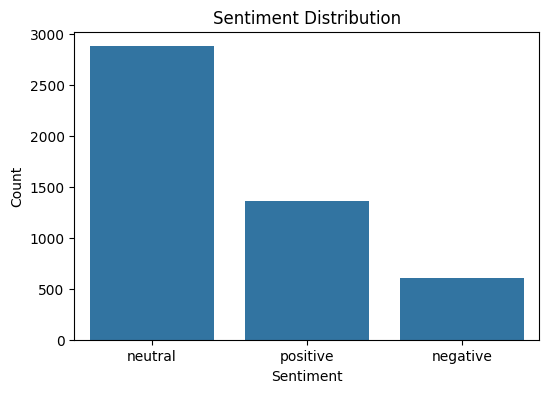

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=data, order=data['sentiment'].value_counts().index)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
##plt.show()

The horizontal bar chart shows the 20 most frequently occurring words in the text data. "eur" and "company" are much more common than other words, with frequencies ranging from 800 to 1000 times; the next ones are "said", "finnish", "mn", "sales", etc., with frequencies gradually decreasing to around 300. Overall, these high-frequency words are mostly related to financial or company reports, such as "profit", "million", "operating", "quarter", etc.

/root/miniconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


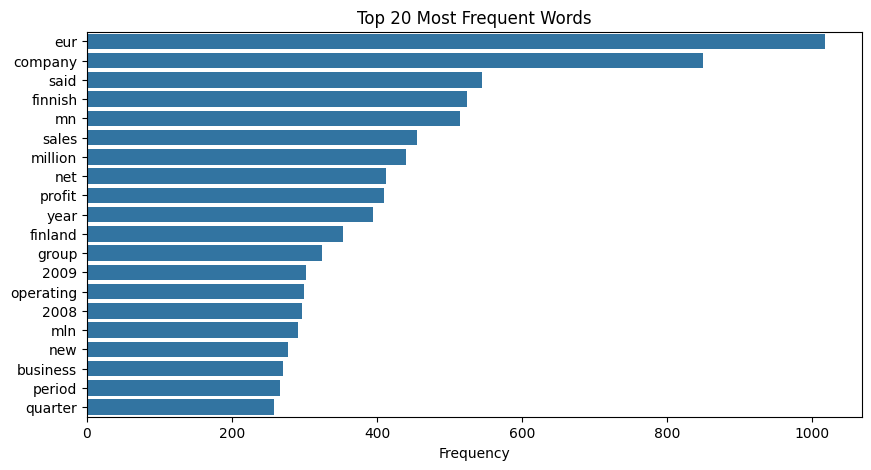

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

# 自定义停用词
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'the', 'of', 'and', 'to', 'in', 'for', 'on', 'at', 'by', 'with',
    'from', 'as', 'an', 'that', 'this', 'it', 'its', 'is', 'be', 'was',
    'are', 'were', 'will', 'would', 'can', 'could', 'should', 'a', 'about', 's'
])
custom_stopwords = list(custom_stopwords)
# 统计词频
vectorizer = CountVectorizer(stop_words=custom_stopwords)
X_counts = vectorizer.fit_transform(data['text'])
word_freq = X_counts.sum(axis=0).A1
vocab = vectorizer.get_feature_names_out()

freq_data = pd.DataFrame({'word': vocab, 'freq': word_freq})
top20 = freq_data.sort_values(by='freq', ascending=False).head(20)

# Top 20 词频柱状图
plt.figure(figsize=(10, 5))
sns.barplot(x='freq', y='word', data=top20)
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('')
plt.show()

## word cloud
Four word clouds illustrate the thematic differences of different emotional corpora: The overall corpus focuses on the business and finance of Finnish enterprises; the neutral corpus objectively describes projects and products; the negative corpus emphasizes the decline in profits and losses; the positive corpus highlights sales growth and profits, reflecting the different emphases of the enterprises' reports from facts to emotions.

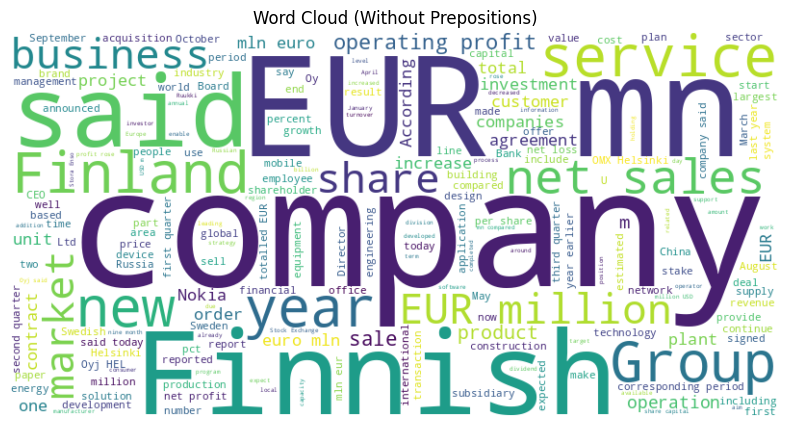

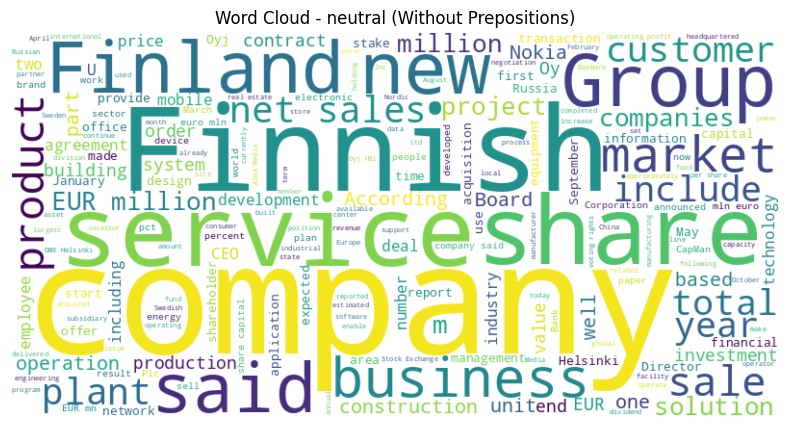

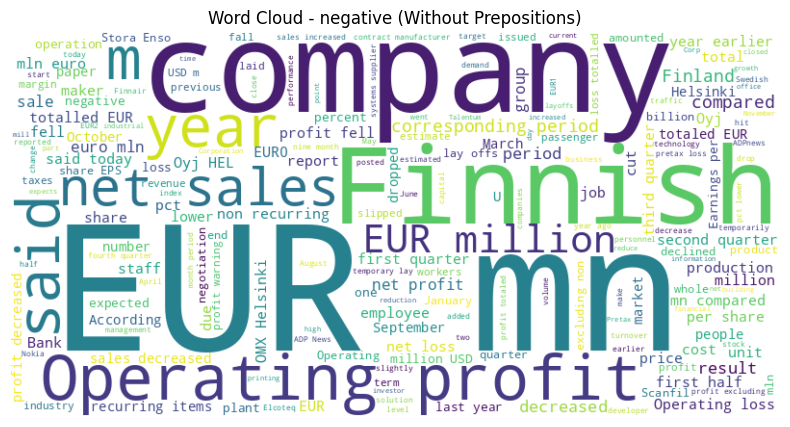

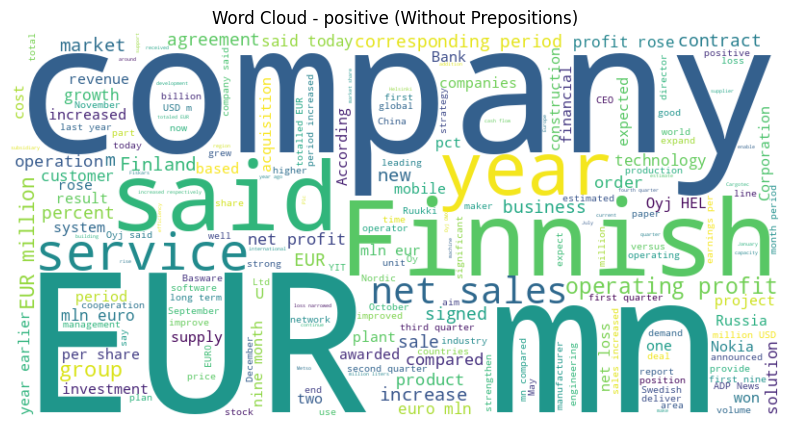

In [6]:
# 整体词云
text_all = ' '.join(data['text'])
wc = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=custom_stopwords
).generate(text_all)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Without Prepositions)')
plt.show()

# 按情感类别词云
for sentiment in data['sentiment'].unique():
    text_subset = ' '.join(data[data['sentiment'] == sentiment]['text'])
    wc = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=custom_stopwords
    ).generate(text_subset)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {sentiment} (Without Prepositions)')
    plt.show()

# Naive Bayes + TF-Idata
**Naive Bayes + TF-IDF** is a method that uses the importance of word occurrence to determine which category a piece of text is more similar to, such as whether it is more positive or negative.

## build model and train

- max tokenizer length set 5000
- remove English stopwords

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-Idata embedding
tfidata = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfi = tfidata.fit_transform(X_train)
X_test_tfi = tfidata.transform(X_test)

In [9]:
from sklearn.naive_bayes import MultinomialNB

# build model
nb = MultinomialNB()
nb.fit(X_train_tfi, y_train, sample_weight=weights)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


## evaluation

Accuracy: 0.6553147574819401
              precision    recall  f1-score   support

    negative       0.42      0.77      0.54       121
     neutral       0.82      0.71      0.76       576
    positive       0.53      0.49      0.51       272

    accuracy                           0.66       969
   macro avg       0.59      0.66      0.60       969
weighted avg       0.69      0.66      0.66       969



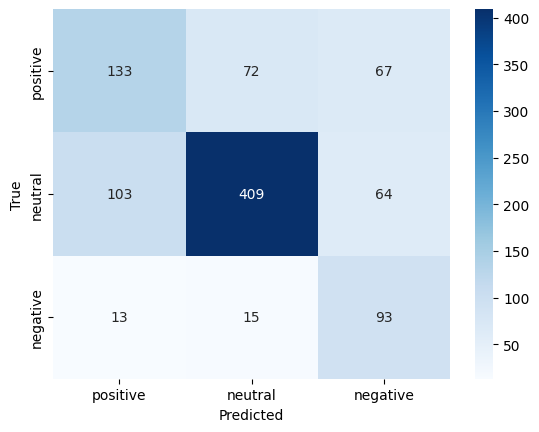

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = nb.predict(X_test_tfi)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['positive', 'neutral', 'negative'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive','neutral','negative'],
            yticklabels=['positive','neutral','negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# LSTM
**LSTM** is a type of neural network that can remember previous information and handle sequential data such as text or time series. It uses a “memory gate” mechanism to keep important information and forget what is unnecessary.

## clean data and encode text

In [11]:
import re, random
import pandas as pd
from collections import Counter
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# clean data
STOP = {
    'the','of','and','to','in','for','on','at','by','with','from','as','an',
    'that','this','it','its','is','be','was','are','were','will','would','can',
    'could','should','a','about','s'
}

def clean(text, remove_stop=True, keep_numbers=True):
    t = text.lower()
    t = re.sub(r'https?://\S+|www\.\S+|\S+@\S+\.\S+', ' ', t)
    t = re.sub(r"’|'|`", " ", t)
    # Replace all characters that are not letters, numbers, periods, decimal points, percent signs or spaces with spaces.
    t = re.sub(r"[^a-z0-9.% ]+", " ", t) 
    toks = [w for w in t.split() if (w not in STOP or not remove_stop)]
    return " ".join(toks)

data_lstm = data.dropna(subset=["text","sentiment"]).copy()
data_lstm["clean"] = data_lstm["text"].apply(lambda x: clean(x, remove_stop=True, keep_numbers=False))

# map label to id
labels = sorted(data_lstm["sentiment"].unique())
label2id = {l:i for i,l in enumerate(labels)}
y_all = torch.tensor([label2id[s] for s in data_lstm["sentiment"]], dtype=torch.long)

# split data into train/test
idx = list(range(len(data_lstm)))
random.seed(42); random.shuffle(idx)
cut = int(0.8*len(idx))
tr_idx, te_idx = idx[:cut], idx[cut:]
train_texts = data_lstm.loc[tr_idx,"clean"].tolist()
test_texts  = data_lstm.loc[te_idx,"clean"].tolist()
y_train = y_all[tr_idx]
y_test  = y_all[te_idx]

# vocab and encode
def build_vocab(texts, vocab_size=30000, min_freq=1):
    cnt = Counter()
    for t in texts:
        cnt.update(t.split())
    vocab = {"<pad>":0, "<unk>":1}
    for w,f in cnt.most_common(vocab_size):
        if f >= min_freq and w not in vocab:
            vocab[w] = len(vocab)
    return vocab

vocab = build_vocab(train_texts, vocab_size=30000, min_freq=1)

def encode(text, vocab):
    return torch.tensor([vocab.get(w, 1) for w in text.split()], dtype=torch.long)  # 1:<unk>

# dataset loader
class TxtDS(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = [encode(t, vocab) for t in texts]
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, i): return self.texts[i], self.labels[i]

def collate(batch, max_len=128):
    xs, ys = zip(*batch)
    xs = [x[:max_len] for x in xs]
    xs_pad = pad_sequence(xs, batch_first=True, padding_value=0)  # 0:<pad>
    return xs_pad, torch.stack(ys)

bs = 32
train_loader = DataLoader(TxtDS(train_texts, y_train, vocab), batch_size=bs, shuffle=True, collate_fn=collate)
test_loader  = DataLoader(TxtDS(test_texts,  y_test,  vocab), batch_size=bs, shuffle=False, collate_fn=collate)


## build model

- add dropout to the model
- apply l2 regularization as a weight decay
- use Adam optimizer
- entropy loss as a criterion

In [12]:
# build lstm model
class LSTMSent(nn.Module):
    def __init__(self, vocab_size, num_labels, emb=128, hid=128, layers=1, bidir=True, dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb, padding_idx=0)
        self.drop_emb = nn.Dropout(0.3)
        self.lstm = nn.LSTM(emb, hid, num_layers=layers, batch_first=True,
                            bidirectional=bidir, dropout=dropout if layers>1 else 0.0)
        outdim = hid*(2 if bidir else 1)
        self.drop_fc = nn.Dropout(0.3)
        self.fc = nn.Linear(outdim, num_labels)

    def forward(self, x):
        mask = (x != 0).float().unsqueeze(-1)
        e = self.emb(x)
        e = self.drop_emb(e) * mask
        out, (h, c) = self.lstm(e)
        if self.lstm.bidirectional:
            h_cat = torch.cat([h[-2], h[-1]], dim=1)
        else:
            h_cat = h[-1]
        h_cat = self.drop_fc(h_cat)
        return self.fc(h_cat)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMSent(vocab_size=len(vocab), num_labels=len(labels)).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-2)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

## train model

- add early stopping for avoiding overfitting

In [13]:
def run_epoch(loader, train=True):
    model.train(train)
    tot, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if train:
            opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        tot += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
    return tot / len(loader.dataset), correct / len(loader.dataset)

best_val = float('inf')
patience = 3
bad = 0
best_state = None
delta = 1e-4  # minimum improvement

for epoch in range(50):  # max epochs
    tr_loss, tr_acc = run_epoch(train_loader, True)
    te_loss, te_acc = run_epoch(test_loader,  False)
    print(f"epoch {epoch+1}: train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {te_loss:.4f} acc {te_acc:.3f}")

    # monitor improvement
    if te_loss < best_val - delta:
        best_val = te_loss
        bad = 0
        # save best model
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        bad += 1
        if bad >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val:.4f}")
            if best_state is not None:
                model.load_state_dict(best_state)
            break

# final test
final_loss, final_acc = run_epoch(test_loader, False)
print(f"final val loss {final_loss:.4f} acc {final_acc:.3f}")

epoch 1: train loss 0.8957 acc 0.621 | val loss 0.8321 acc 0.659
epoch 2: train loss 0.7669 acc 0.700 | val loss 0.8411 acc 0.651
epoch 3: train loss 0.6334 acc 0.777 | val loss 0.8508 acc 0.659
epoch 4: train loss 0.5140 acc 0.840 | val loss 0.8618 acc 0.691
Early stopping at epoch 4. Best val loss: 0.8321
final val loss 0.8321 acc 0.659


## evaluation

Accuracy: 0.6594427244582043
Test classification report
               precision    recall  f1-score   support

    negative     0.8462    0.0909    0.1642       121
     neutral     0.6920    0.9235    0.7912       562
    positive     0.5291    0.3811    0.4431       286

    accuracy                         0.6594       969
   macro avg     0.6891    0.4652    0.4661       969
weighted avg     0.6632    0.6594    0.6101       969



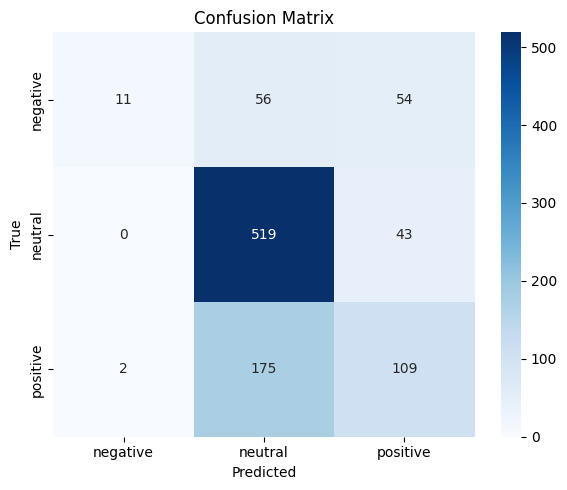

In [14]:
@torch.no_grad()
def predict_loader(loader, model, device):
    model.eval()
    all_pred, all_true = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x) # predict
        pred = logits.argmax(1)
        all_pred.extend(pred.cpu().tolist())
        all_true.extend(y.cpu().tolist())
    return np.array(all_true), np.array(all_pred)

# ---evaluation---
y_true, y_pred = predict_loader(test_loader, model, device)

classes = labels
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Test classification report\n",
      classification_report(y_true, y_pred, target_names=classes, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.tight_layout(); plt.show()

# FinBERT-tone

[**FinBERT**](https://huggingface.co/yiyanghkust/finbert-tone) was developed by the research team of our university, The Hong Kong University of Science and Technology (HKUST). It is based on the BERT-base structure and has been fine-tuned on financial news and financial sentiment corpora.

check gpu

In [15]:
import torch
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("device count:", torch.cuda.device_count())
    print("name:", torch.cuda.get_device_name(0))
    print("torch cuda version:", torch.version.cuda)

cuda available: True
device count: 1
name: NVIDIA vGPU-32GB
torch cuda version: 12.8


## load FinBERT-tone

In [ ]:
!huggingface-cli login
!huggingface-cli download yiyanghkust/finbert-tone --local-dir ./finbert-tone --resume-download

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("./finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("./finbert-tone")
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## directly predict without training

In [17]:
texts = data['text'].tolist()

batch_size = 32
pred_ids = []

with torch.no_grad():
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)
        logits = model(**inputs).logits
        pred_ids.extend(logits.argmax(dim=1).tolist())


In [18]:
id2label = {0: "neutral", 1: "positive", 2: "negative"}
data_bert['bert_pred'] = [id2label[i] for i in pred_ids]
data_bert[['sentiment','bert_pred']].head()

,sentiment,bert_pred
0,neutral,neutral
1,negative,neutral
2,positive,positive
3,positive,positive
4,positive,positive


## evaluate

Accuracy: 0.7925696594427245
              precision    recall  f1-score   support

    negative     0.7942    0.6838    0.7349       604
     neutral     0.7883    0.9187    0.8485      2878
    positive     0.8064    0.5745    0.6710      1363

    accuracy                         0.7926      4845
   macro avg     0.7963    0.7256    0.7515      4845
weighted avg     0.7941    0.7926    0.7844      4845



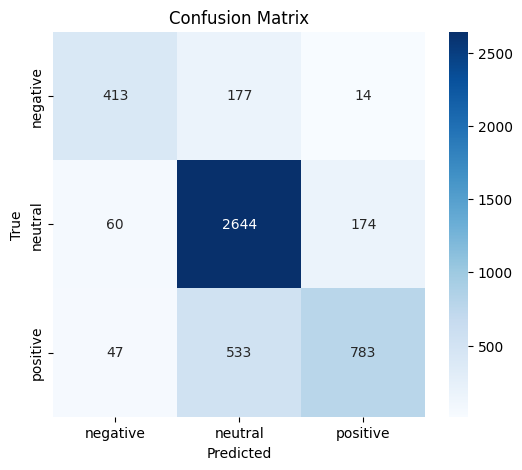

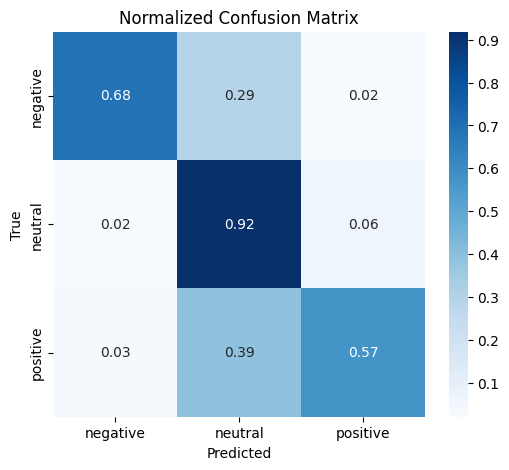

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 统一大小写与空白
gold = data_bert['sentiment'].astype(str)
pred = data_bert['bert_pred'].astype(str)

# check consistency
labels = ['negative','neutral','positive']
assert set(gold.unique()) - set(labels) == set(), f"存在未知金标: {set(gold.unique())-set(labels)}"
assert set(pred.unique()) - set(labels) == set(), f"存在未知预测: {set(pred.unique())-set(labels)}"

print("Accuracy:", accuracy_score(gold, pred))

# evaluation
print(classification_report(gold, pred, labels=labels, target_names=labels, digits=4))

# confusion matrix
cm = confusion_matrix(gold, pred, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# normalized confusion matrix by percentage
cmn = confusion_matrix(gold, pred, labels=labels, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Normalized Confusion Matrix')
plt.show()

# Fine-tuning FinBERT-tone

In [20]:
# "rd" for raw data
rd = data.iloc[:, :2].copy()
rd.columns = ['sentiment','text']
rd['sentiment'] = rd['sentiment'].astype(str).str.strip()
rd['text'] = rd['text'].astype(str).str.strip()

import numpy as np
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

le_b = LabelEncoder()
rd['label_b'] = le_b.fit_transform(rd['sentiment'])  # 0..2

Xtr_b, Xtmp_b, ytr_b, ytmp_b = train_test_split(
    rd['text'], rd['label_b'], test_size=0.2, random_state=42, stratify=rd['label_b']
)
Xva_b, Xte_b, yva_b, yte_b = train_test_split(
    Xtmp_b, ytmp_b, test_size=0.5, random_state=42, stratify=ytmp_b
)

train_ds_b = Dataset.from_dict({"text": Xtr_b.tolist(), "label": ytr_b.tolist()})
val_ds_b   = Dataset.from_dict({"text": Xva_b.tolist(), "label": yva_b.tolist()})
test_ds_b  = Dataset.from_dict({"text": Xte_b.tolist(), "label": yte_b.tolist()})

# tokenizer
model_name = "./finbert-tone"
tokenizer_b = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn_b(ex):
    return tokenizer_b(ex["text"], truncation=True, max_length=128)

train_tok_b = train_ds_b.map(tokenize_fn_b, batched=True, remove_columns=["text"])
val_tok_b   = val_ds_b.map(tokenize_fn_b,   batched=True, remove_columns=["text"])
test_tok_b  = test_ds_b.map(tokenize_fn_b,  batched=True, remove_columns=["text"])

collator_b = DataCollatorWithPadding(tokenizer=tokenizer_b)

# model
num_labels_b = len(le_b.classes_)
model_b = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels_b)
if torch.cuda.is_available():
    model_b.to("cuda")
    
# set metrics
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics_b(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

# train
args_b = TrainingArguments(
    output_dir="finbert_finetune_b",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",  
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    fp16=torch.cuda.is_available(),
    logging_steps=20,
    logging_first_step=True,
    disable_tqdm=False,
    report_to="none" 
)

trainer_b = Trainer(
    model=model_b,
    args=args_b,
    train_dataset=train_tok_b,
    eval_dataset=val_tok_b,
    tokenizer=tokenizer_b,
    data_collator=collator_b,
    compute_metrics=compute_metrics_b
)

trainer_b.train()

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

/tmp/ipykernel_1980/3624645557.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_b = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.427300,0.397043,0.836777,0.804636
2,0.290400,0.398931,0.859504,0.841863
3,0.175100,0.450869,0.869835,0.855931


TrainOutput(global_step=729, training_loss=0.4679841331330183, metrics={'train_runtime': 48.1935, 'train_samples_per_second': 241.277, 'train_steps_per_second': 15.127, 'total_flos': 344238684478416.0, 'train_loss': 0.4679841331330183, 'epoch': 3.0})

## evaluation

Accuracy: 0.8804123711

              precision    recall  f1-score   support

    negative     0.8615    0.9180    0.8889        61
     neutral     0.9149    0.8958    0.9053       288
    positive     0.8188    0.8309    0.8248       136

    accuracy                         0.8804       485
   macro avg     0.8651    0.8816    0.8730       485
weighted avg     0.8812    0.8804    0.8806       485



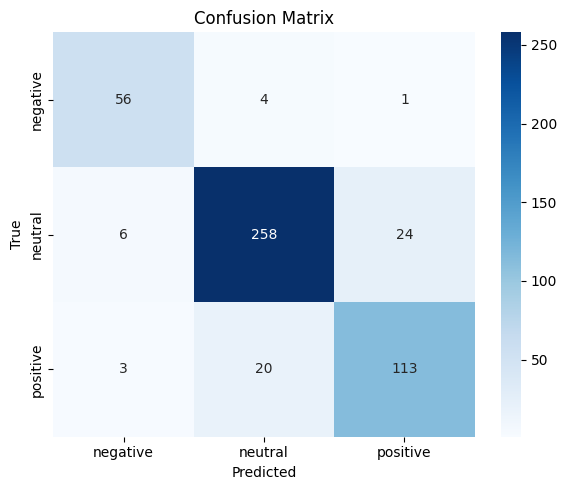

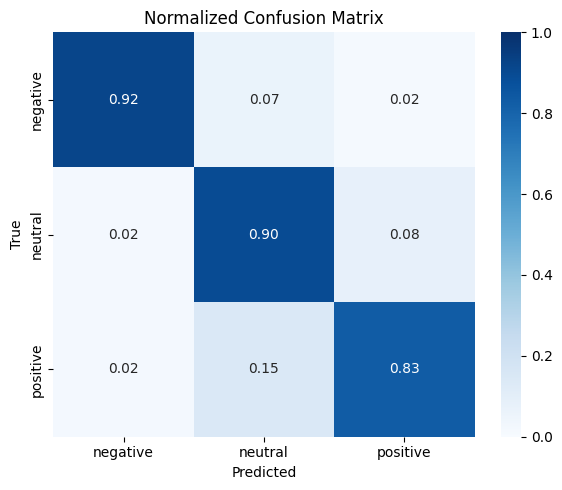

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# predict
pred_test_b = trainer_b.predict(test_tok_b)
y_pred_b = pred_test_b.predictions.argmax(axis=1)
y_true_b  = np.asarray(yte_b)


classes = list(le_b.classes_)          # ['negative','neutral','positive']
labels_idx = list(range(len(classes)))  # [0,1,2]


acc = accuracy_score(y_true_b, y_pred_b)
print(f"Accuracy: {acc:.10f}\n")
print(classification_report(y_true_b, y_pred_b,
                            labels=labels_idx,
                            target_names=classes,
                            digits=4))

# confusion_matrix
cm = confusion_matrix(y_true_b, y_pred_b, labels=labels_idx)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# confusion_matrix by percentage
cm_norm = confusion_matrix(y_true_b, y_pred_b, labels=labels_idx, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            vmin=0, vmax=1,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

In [33]:
# map label
classes = list(le_b.classes_)                    # ['negative','neutral','positive']
id2label = {i: c for i, c in enumerate(classes)}
label2id = {c: i for i, c in enumerate(classes)}

model_b.config.id2label = id2label
model_b.config.label2id = label2id
print(model_b.config.id2label)  # 检查应为 {0:'negative',1:'neutral',2:'positive'}

{0: 'negative', 1: 'neutral', 2: 'positive'}


# 	5.	Application New Data

search new data [**chiapudding/kaggle-financial-sentiment**](https://huggingface.co/datasets/chiapudding/kaggle-financial-sentiment) to test if the model works better as well on other financial data.

## Load data

In [28]:
import pandas as pd
new_data = pd.read_csv("new_data.csv", encoding="ISO-8859-1")
new_data = new_data.iloc[:, :2].copy()
new_data.columns = ['text','sentiment']
new_data

,text,sentiment
0,A few employees would remain at the Oulu plant...,neutral
1,Comparable net sales are expected to increase ...,positive
2,"Tesla is recalling 2,700 Model X cars: https:/...",negative
3,Finnish software developer Done Solutions Oyj ...,positive
4,Compagnie de Financement Foncier - Is to issue...,neutral
...,...,...
1164,"In 2010 , the Marimekko Group s net sales were...",neutral
1165,Nokia said it still expects to sell 150 more m...,neutral
1166,"PNC, Goldman Sachs Receive Dividend Hike Green...",positive
1167,"The company , employing 6,400 , reported net s...",neutral


## Predict with Fine-tuning FinBERT-tone

In [ ]:
# import torch
# import numpy as np
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from sklearn.metrics import classification_report, accuracy_score

# # 1) 加载微调后的模型与分词器（换成你的checkpoint路径）
# ckpt = "./model_b"   # 例如: trainer_b.save_model("model_b") 之后的目录
# tokenizer_b = AutoTokenizer.from_pretrained(ckpt)
# model_b = AutoModelForSequenceClassification.from_pretrained(ckpt)
# model_b.eval()

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_b.to(device)

# predict function
def predict_texts(texts, batch_size=32, max_length=128):
    pred_ids = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = tokenizer_b(batch, padding=True, truncation=True,
                               return_tensors="pt", max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            logits = model_b(**inputs).logits
            pred_ids.extend(logits.argmax(dim=1).cpu().tolist())
    
    id2label = model_b.config.id2label
    preds = [id2label[int(i)] for i in pred_ids]
    return preds

# predict to new_data
texts = new_data["text"].astype(str).tolist()
new_data["bert_pred"] = predict_texts(texts, batch_size=32, max_length=128)
new_data.head()

,text,sentiment,bert_pred
0,A few employees would remain at the Oulu plant...,neutral,neutral
1,Comparable net sales are expected to increase ...,positive,positive
2,"Tesla is recalling 2,700 Model X cars: https:/...",negative,neutral
3,Finnish software developer Done Solutions Oyj ...,positive,positive
4,Compagnie de Financement Foncier - Is to issue...,neutral,neutral


## evaluation

Accuracy: 0.7682

              precision    recall  f1-score   support

    negative     0.5322    0.7086    0.6078       175
     neutral     0.7783    0.8183    0.7978       622
    positive     0.9397    0.7124    0.8104       372

    accuracy                         0.7682      1169
   macro avg     0.7501    0.7464    0.7387      1169
weighted avg     0.7928    0.7682    0.7734      1169



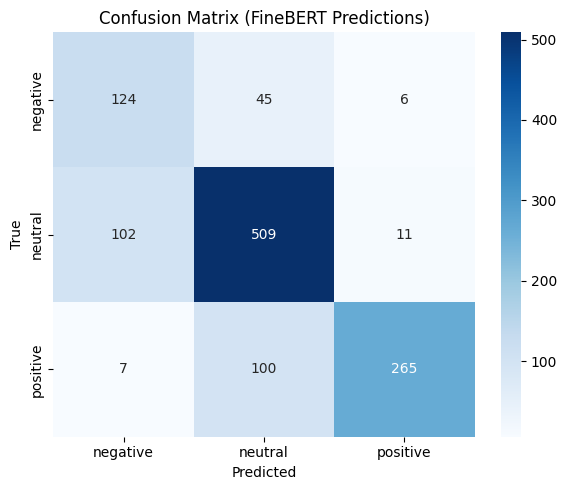

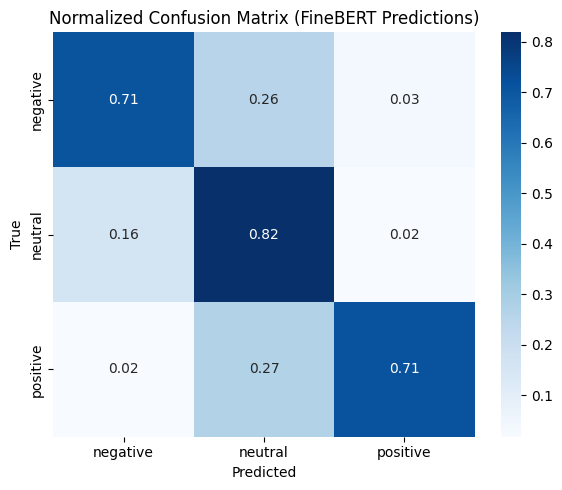

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# align with gold and pred
gold = new_data['sentiment'].astype(str).str.lower().str.strip()
pred = new_data['bert_pred'].astype(str).str.lower().str.strip()

# make sure all labels are known
labels = ['negative','neutral','positive']
assert set(gold.unique()) <= set(labels), f"存在未知金标: {set(gold.unique())-set(labels)}"
assert set(pred.unique()) <= set(labels), f"存在未知预测: {set(pred.unique())-set(labels)}"

# compute accuracy
acc = accuracy_score(gold, pred)
print(f"Accuracy: {acc:.4f}\n")


print(classification_report(gold, pred, labels=labels, target_names=labels, digits=4))

# confusion matrix
cm = confusion_matrix(gold, pred, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (FinBERT Predictions)')
plt.tight_layout()
plt.show()

# confusion matrix normalized by percentage
cmn = confusion_matrix(gold, pred, labels=labels, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (FinBERT Predictions)')
plt.tight_layout()
plt.show()

## predict with original FinBERT-tone

In [43]:
import torch, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("../finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("../finbert-tone").to(device).eval()

def predict_texts_finbert(texts, batch_size=32, max_length=128):
    pred_ids = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(batch, padding=True, truncation=True,
                            max_length=max_length, return_tensors="pt").to(device)
            logits = model(**enc).logits
            pred_ids += logits.argmax(1).cpu().tolist()
    id2label = model.config.id2label            # 使用模型自带映射
    return [id2label[int(i)] for i in pred_ids]

texts = new_data["text"].astype(str).tolist()
new_data["bert_pred"] = predict_texts_finbert(texts)

Accuracy: 0.6946

              precision    recall  f1-score   support

    negative     0.5075    0.5829    0.5426       175
     neutral     0.6909    0.8264    0.7526       622
    positive     0.8750    0.5269    0.6577       372

    accuracy                         0.6946      1169
   macro avg     0.6911    0.6454    0.6509      1169
weighted avg     0.7220    0.6946    0.6909      1169



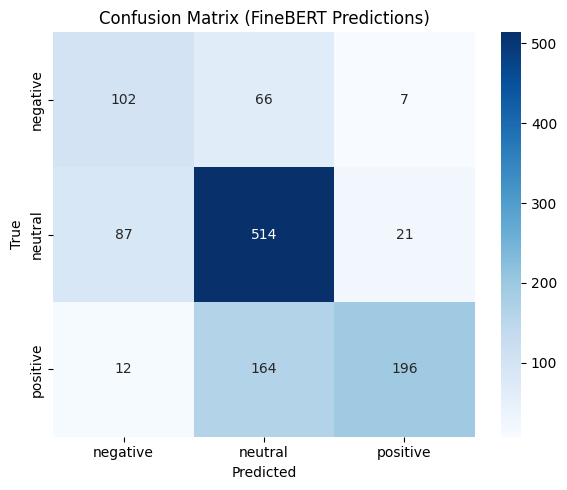

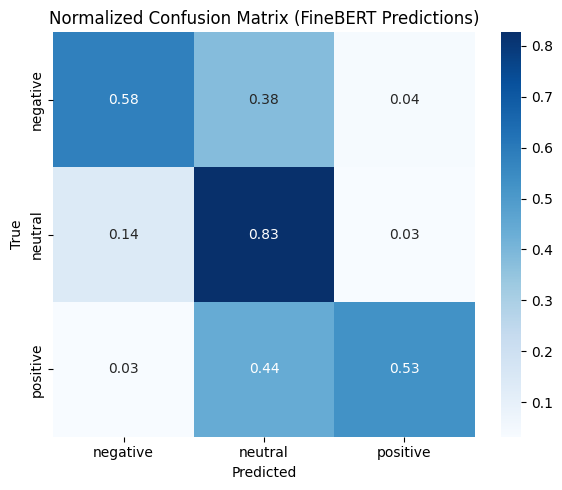

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# algin with gold and pred
gold = new_data['sentiment'].astype(str).str.lower().str.strip()
pred = new_data['bert_pred'].astype(str).str.lower().str.strip()

# make sure all labels are known
labels = ['negative','neutral','positive']
assert set(gold.unique()) <= set(labels), f"存在未知金标: {set(gold.unique())-set(labels)}"
assert set(pred.unique()) <= set(labels), f"存在未知预测: {set(pred.unique())-set(labels)}"

# compute accuracy
acc = accuracy_score(gold, pred)
print(f"Accuracy: {acc:.4f}\n")


print(classification_report(gold, pred, labels=labels, target_names=labels, digits=4))

# confusion matrix
cm = confusion_matrix(gold, pred, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (FinBERT Predictions)')
plt.tight_layout()
plt.show()

# confusion matrix normalized by percentage
cmn = confusion_matrix(gold, pred, labels=labels, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (FinBERT Predictions)')
plt.tight_layout()
plt.show()